In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes
from pygimli.physics.ert import createERTData, ERTModelling

## Modèle

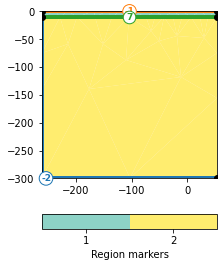

In [2]:
left = mt.createWorld(start=[-261.5, -300], end=[54, 0], layers=[-11])
for b in left.boundaries():
    if b.center().x() == 54:
        b.setMarker(0)

pg.viewer.showMesh(left, markers=True, showBoundary=True);

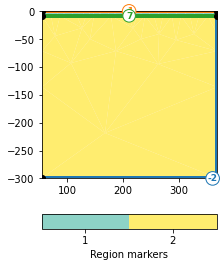

In [3]:
right = mt.createWorld(start=[54, -300], end=[368, 0], layers=[-8])
for b in right.boundaries():
    if b.center().x() == 54:
        b.setMarker(0)

pg.viewer.showMesh(right, markers=True, showBoundary=True);

Mesh: Nodes: 10 Cells: 0 Boundaries: 14

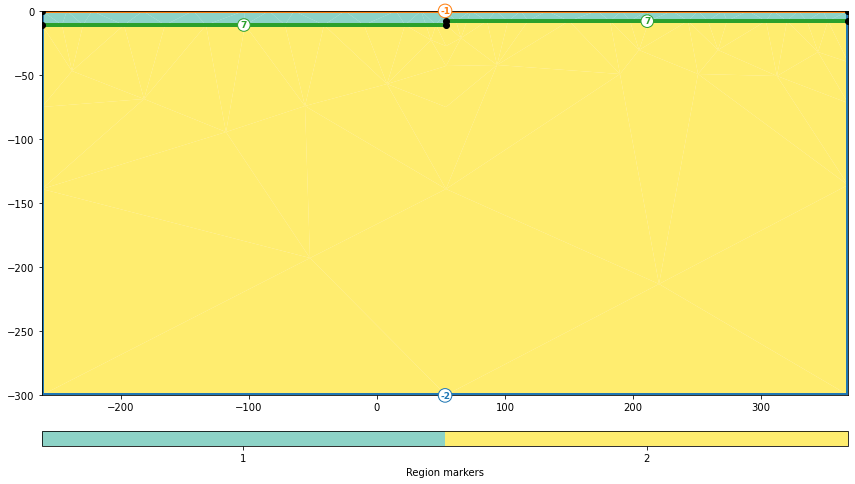

In [4]:
plc = mt.mergePLC([left, right])
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(plc, markers= True, ax=ax)
plc

Mesh: Nodes: 25 Cells: 0 Boundaries: 33

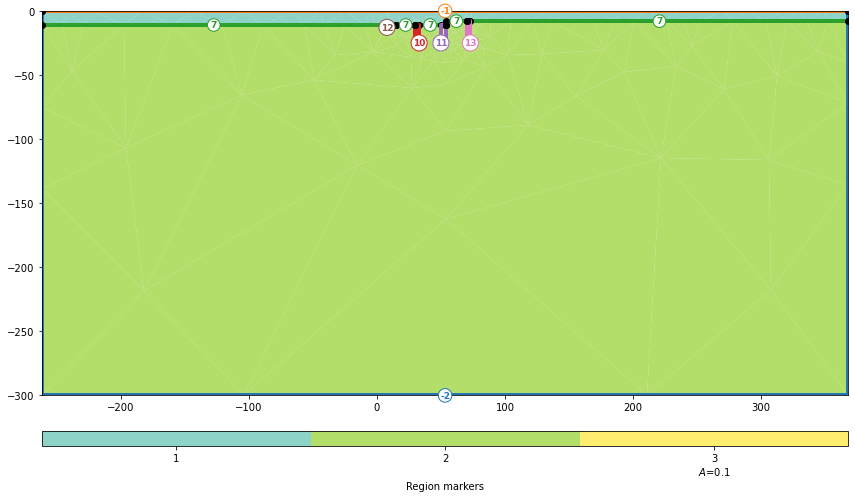

In [5]:
anomalie = mt.createRectangle(start=[30, -11], end=[33, -25], marker=3, area=0.1, boundaryMarker=10)
anomalie2 = mt.createRectangle(start=[50, -11], end=[54, -25], marker=3, area=0.1, boundaryMarker=11)
anomalie4 = mt.createPolygon([[15, -11], [11, -15], [9, -15], [7, -11]], isClosed=True, marker=3, area=0.1, boundaryMarker=12, interpolate='spline')
anomalie5 = mt.createRectangle(start=[70, -8], end=[73, -25], marker=3, area=0.1, boundaryMarker=13)
#anomalie6 = mt.createCircle(pos=[92,-22.5], radius=[3, 2], marker=4,
                        #boundaryMarker=14, area=0.1) #salle

plc += anomalie
plc += anomalie2
plc += anomalie4
plc += anomalie5
#plc += anomalie6
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(plc, markers= True, ax=ax)
plc

## Réseau d'électrodes

In [6]:
shmgeo = pg.load("aadip_dipsurf.dat")

In [7]:
shm = pg.load("aashm1.dat")
shm.add(pg.load("aadip_dipsurf1.dat"))
# shm.add(pg.load("aa15.dat"))
# shm.add(pg.load("aa6.dat"))
# shm.add(pg.load("aa13.dat"))
# shm.add(pg.load("aa4sim.dat"))
# shm.add(pg.load("aa8.dat"))
# shm.add(pg.load("aa9.dat")) 
# shm.add(pg.load("aa4enterres.dat")) 
shm

Data: Sensors: 72 data: 2848, nonzero entries: ['a', 'b', 'err', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']

## Maillage

In [8]:
for s in shm.sensors():
    plc.createNode(s, marker=-99)
    plc.createNode(s - [0, 0.01])

plc #30 nodes + 18 * 2 (electrodes) = 66 nodes

Mesh: Nodes: 168 Cells: 0 Boundaries: 33

(<AxesSubplot:>, None)

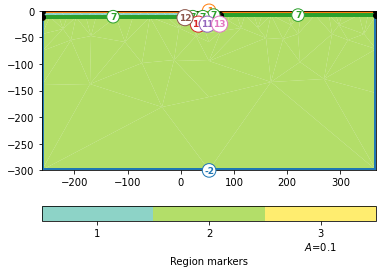

In [9]:
pg.show(plc, markers=True)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2498dbf5e20>)

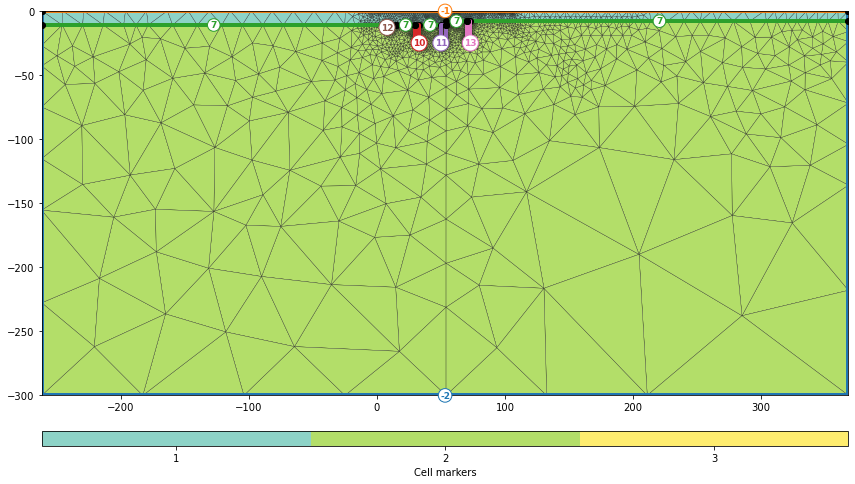

In [10]:
mesh = mt.createMesh(plc, quality=34)
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(mesh, markers=True, showMesh=True,ax=ax)

## Rho effectives

(<AxesSubplot:xlabel='x [m]', ylabel='z [m]'>,
 <matplotlib.colorbar.Colorbar at 0x2498e67c370>)

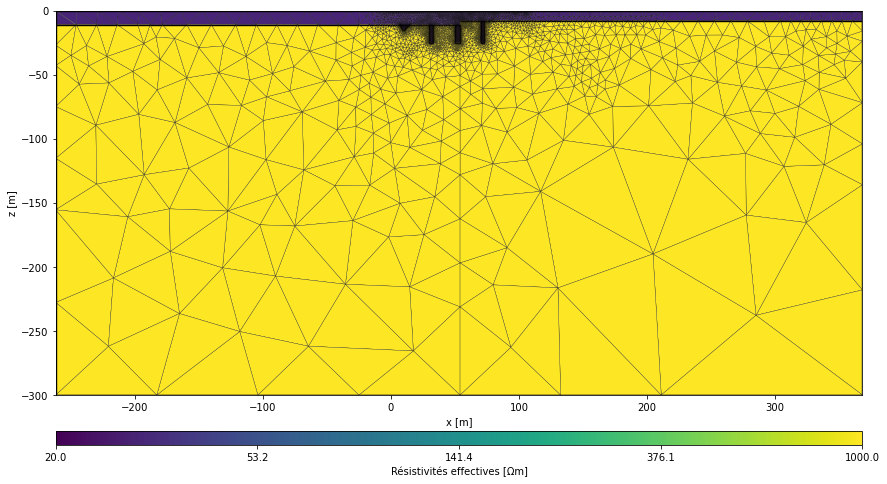

In [11]:
rhomap = [ [1, 30],    #couverture
           [2, 1000],  #calcaire
           [3, 20]]    #fontis
           #[4, 50]]    #salle
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(mesh, data=rhomap, label='Résistivités effectives [Ωm]', ax=ax,showMesh=True,logScale=True, xlabel='x [m]', ylabel='z [m]')#, cMap="tab10")
# plt.savefig('Tof/modelekarst.pdf')

(<AxesSubplot:>, None)

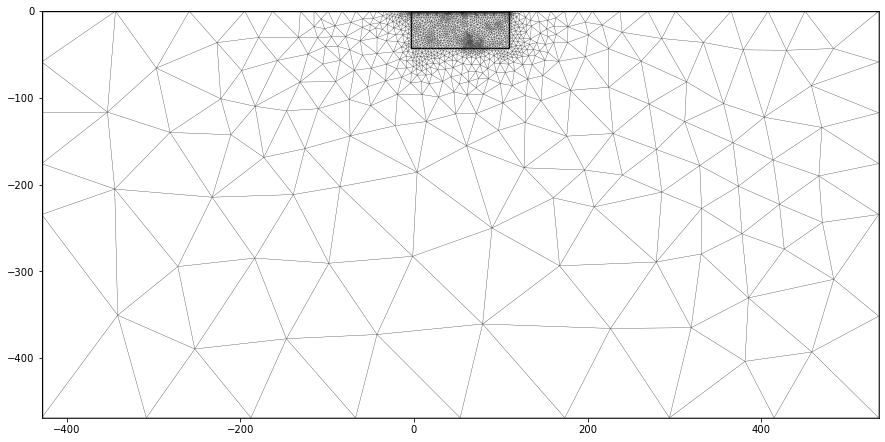

In [14]:
geo=pg.meshtools.createParaMeshPLC(shmgeo,paraMaxCellSize=6)
for p in data.sensors():
    geo.createNode(p)
    geo.createNode(p - [0, 0.1])
mesh_invplc = pg.meshtools.createMesh(geo, quality=34)
fig, ax = plt.subplots(figsize=(15, 8))
pg.show(mesh_invplc, ax=ax, markers=False)

In [225]:
noiseLevel=0.03
noiseAbs =5e-5

## Simulation calcul bruit ert.simulate

In [226]:
data = ert.simulate(mesh, scheme=shm, res=rhomap, noiseLevel=noiseLevel,
                    noiseAbs=noiseAbs, seed=1337)

Data error estimate (min:max)  0.030015622714171405 : 0.03866232647327619


In [227]:
pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

03/06/22 - 16:46:59 - pyGIMLi - INFO - 1.7105343145084746 2217.1321245488066
03/06/22 - 16:46:59 - pyGIMLi - INFO - Simulated data Data: Sensors: 72 data: 2848, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
03/06/22 - 16:46:59 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
03/06/22 - 16:46:59 - pyGIMLi - INFO - Simulated rhoa (min/max) 26.1117055283628 105.4263396911131
03/06/22 - 16:46:59 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0015622714171406 3.866232647327619


In [99]:
mgr = ert.ERTManager('simulated.dat')
inv = mgr.invert(data = data, mesh=mesh_invplc, lam=30, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

03/06/22 - 15:58:29 - pyGIMLi - INFO - Found 2 regions.
03/06/22 - 15:58:29 - pyGIMLi - INFO - Region with smallest marker (1) set to background
03/06/22 - 15:58:29 - pyGIMLi - CRITICAL - <class 'pygimli.physics.ert.ertManager.ERTManager'>.checkData(C:\Users\franc\anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ertManager.py:402)
Found negative apparent resistivities. These can't be processed with logarithmic data transformation. You should consider to filter them out using data.remove(data['rhoa'] < 0).


62 [978, 1835, 2040, 2065, 2082, 2084, 2093, 2097, 2111, 2115, 2130, 2178, 2188, 2201, 2267, 2319, 2336, 2342, 2354, 2356, 2375, 2382, 2384, 2397, 2398, 2427, 2445, 2471, 2474, 2478, 2488, 2504, 2522, 2530, 2575, 2600, 2606, 2620, 2625, 2637, 2641, 2642, 2655, 2656, 2658, 2664, 2687, 2704, 2706, 2712, 2714, 2717, 2721, 2725, 2728, 2739, 2768, 2773, 2788, 2814, 2844, 2847]
62 [-0.7840311523651716, -2.2244565697799055, -20.09672120750947, -7.938280927382656, -20.100319666404715, -39.061298561024785, -0.1452628042369242, -24.267071878224954, -16.425616581947178, -7.181262482371486, -0.42470723251675646, -3.1183936878637555, -3.628031126940785, -0.4075573954603061, -7.744493482008007, -40.14214407395317, -18.43438538366873, -62.21207986462415, -11.03250334969217, -29.55832971500813, -35.17146363857268, -31.0615921028557, -26.731931416920208, -19.269870922848515, -24.53400006189108, -49.69018980702902, -73.0151763898676, -3.0488422814988074, -10.999834603865095, -9.570776845044074, -4.00954

Exception: Found negative apparent resistivities. These can't be processed with logarithmic data transformation. You should consider to filter them out using data.remove(data['rhoa'] < 0).

In [16]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}

In [17]:
modelP = mgr.paraModel(inv)  # do the mapping
loadmesh = mgr.paraDomain

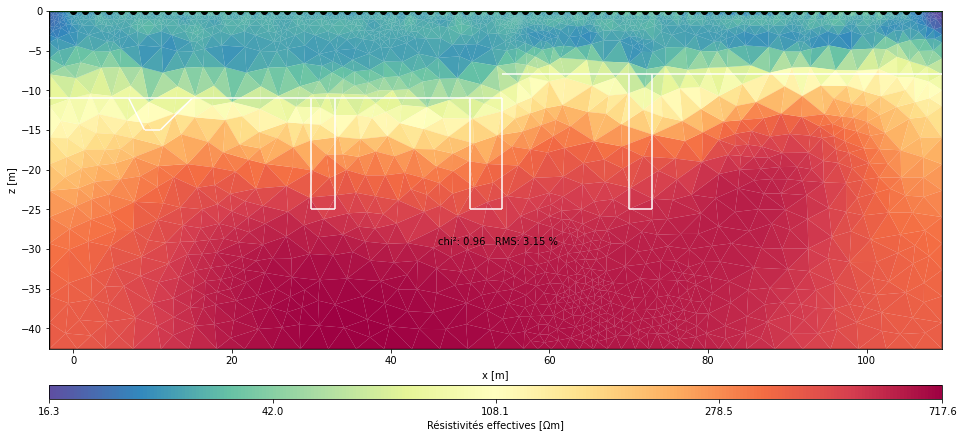

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')

03/06/22 - 15:06:34 - pyGIMLi - INFO - Saving resistivity data to: .\20220603-15.06\ERTManager


('.\\20220603-15.06\\ERTManager',
 <Figure size 1152x720 with 2 Axes>,
 <AxesSubplot:>)

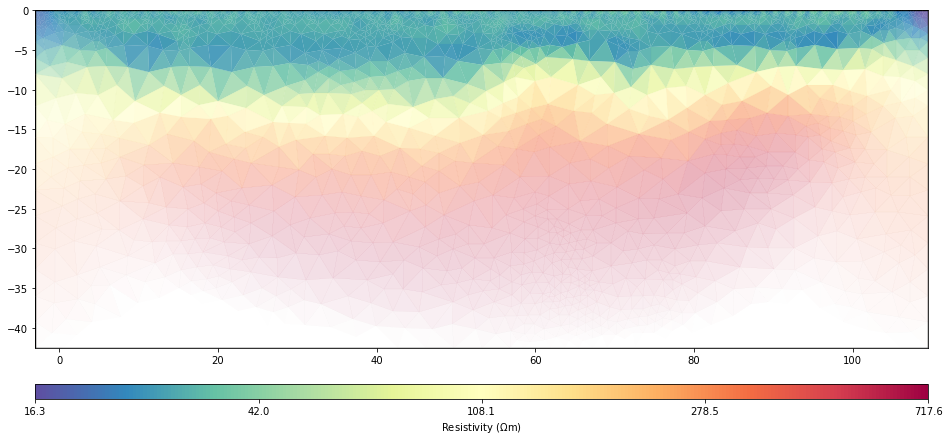

In [19]:
mgr.saveResult()

## Simulation calcul bruit à la main

In [100]:
hom = ert.simulate(mesh_invplc, res=1.0, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)

hom.save('homogeneous.ohm', 'a b m n u')

1

In [228]:
data1 = ert.simulate(mesh, res=rhomap, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)
#pg.show(mesh, notebook=True)

In [229]:
## u = u simulate +noise

In [230]:
data1('u')

2848 [3.1722945254675246,...,-0.012423735226974264]

In [231]:
data1['err'] = ert.estimateError(data1, absoluteUError=noiseAbs, relativeError=noiseLevel) #50microV et 3%

In [233]:
noise = data1('u')*data1('err') * pg.randn(data1.size(), seed=1337)

In [234]:
# noise = 0.03+ 5e-5/pg.abs(data1('u'))

In [235]:
noise

2848 [-0.06695667696913594,...,0.0007507738514752441]

In [236]:
data1.set('u', data1('u') + noise)

In [241]:
data1.set('k', 1.0/ (hom('u') / hom('i')))
# data1.set('k', data('k'))
data1.set('rhoa', data1('k') * data1('u') / data1('i'))

# data1['err'] = ert.estimateError(data1, absoluteUError=5e-3, relativeError=0.2) #50microV et 3%

data1.save('simulated.dat', 'a b m n rhoa k u i err')

1

In [238]:
pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

03/06/22 - 16:47:09 - pyGIMLi - INFO - Simulated rhoa (min/max) 26.1117055283628 105.4263396911131
03/06/22 - 16:47:09 - pyGIMLi - INFO - Selected data noise %(min/max) 3.0015622714171406 3.866232647327619


In [239]:
pg.info(np.linalg.norm(data1['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data1)
pg.info('The data contains:', data1.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data1['rhoa']), max(data1['rhoa']))
pg.info('Selected data1 noise %(min/max)', min(data1['err'])*100, max(data1['err'])*100)
pg.info('Selected data1 noise %(min/max)2', min(data1['err2'])*100, max(data1['err2'])*100)

03/06/22 - 16:47:09 - pyGIMLi - INFO - 1.710462015452739 2217.1321245488066
03/06/22 - 16:47:09 - pyGIMLi - INFO - Simulated data Data: Sensors: 72 data: 2848, nonzero entries: ['a', 'b', 'err', 'err2', 'i', 'k', 'm', 'n', 'rhoa', 'u', 'valid']
03/06/22 - 16:47:10 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'err2', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
03/06/22 - 16:47:10 - pyGIMLi - INFO - Simulated rhoa (min/max) 26.346378924663238 104.45144072106739
03/06/22 - 16:47:10 - pyGIMLi - INFO - Selected data1 noise %(min/max) 3.0015559013177286 3.8734639987628814
03/06/22 - 16:47:10 - pyGIMLi - INFO - Selected data1 noise %(min/max)2 -10.409714940205147 11.639154082905595


In [51]:
mgr = ert.ERTManager('simulated.dat')
inv = mgr.invert(data = data, mesh=mesh_invplc, lam=30, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

03/06/22 - 15:22:03 - pyGIMLi - INFO - Found 2 regions.
03/06/22 - 15:22:03 - pyGIMLi - INFO - Region with smallest marker (1) set to background
03/06/22 - 15:22:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
03/06/22 - 15:22:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
03/06/22 - 15:22:06 - pyGIMLi - INFO - Use median(data values)=32.508502095324985
03/06/22 - 15:22:06 - pyGIMLi - INFO - Created startmodel from forward operator: 5451 [32.508502095324985,...,32.508502095324985]
03/06/22 - 15:22:06 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000249BE12C680>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000249BE13A540>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000249BE13A860>
min/max (data): 26.11/105
min/max (error): 3%/3.87%
min/max (start model): 32.51/32.51
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.8 (dPhi = 95.58%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.42 (dPhi = 17.71%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.34 (dPhi = 4.28%) lam: 30.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.13 (dPhi = 9.81%) lam: 30.0
--------------------------------------------------------

In [52]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}

In [53]:
modelP = mgr.paraModel(inv)  # do the mapping
loadmesh = mgr.paraDomain

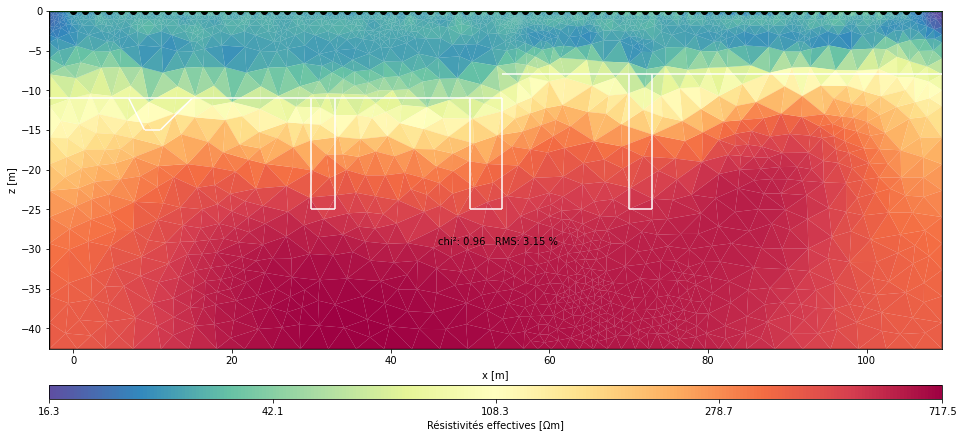

In [54]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')

03/06/22 - 15:29:21 - pyGIMLi - INFO - Saving resistivity data to: .\20220603-15.29\ERTManager


('.\\20220603-15.29\\ERTManager',
 <Figure size 1152x720 with 2 Axes>,
 <AxesSubplot:>)

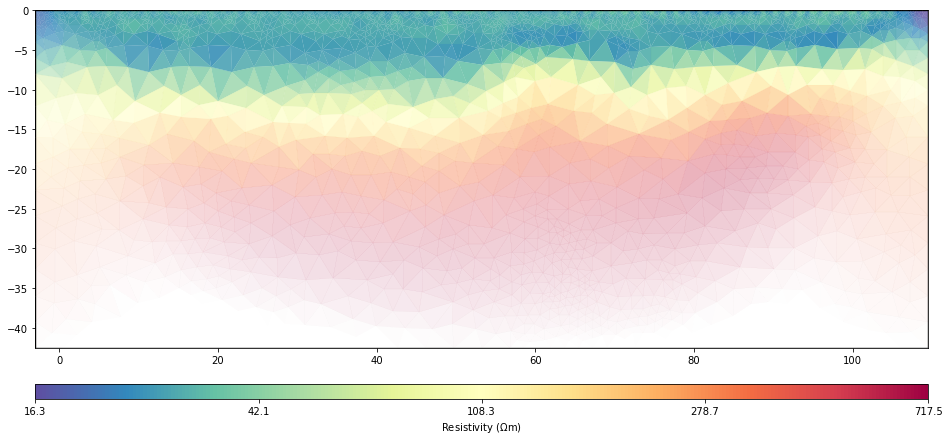

In [55]:
mgr.saveResult()

(0.5, 1.5)

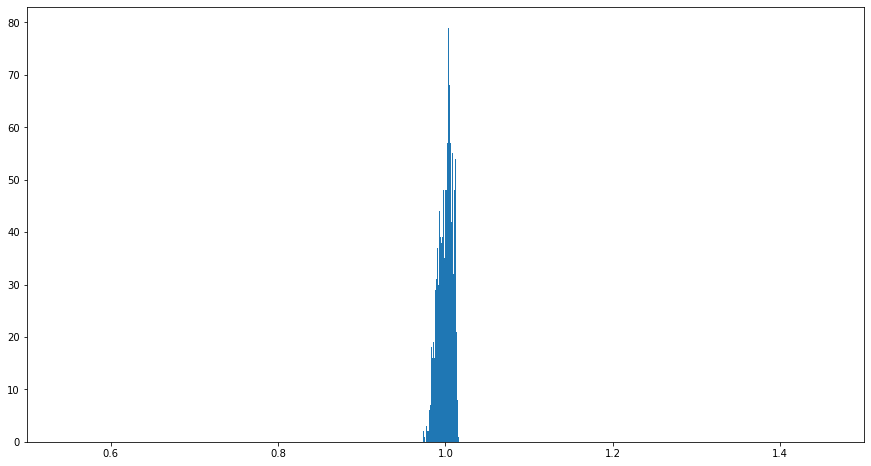

In [242]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(np.array(data('rhoa')/data1('rhoa')), bins=100);
ax.set_xlim(0.5,1.5)

In [75]:
udata = data('rhoa')/data('k')
udata

2848 [3.122277958823689,...,-0.011572972832990315]

In [73]:
data1('u')

2848 [3.1053378484983885,...,-0.01167296137549902]

In [ ]:
hom = ert.simulate(mesh, res=1.0, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)

hom.save('homogeneous.ohm', 'a b m n u')

In [ ]:
data = ert.simulate(mesh, res=rhomap, scheme=shm, sr=False,
                   calcOnly=True, verbose=True)
#pg.show(mesh, notebook=True)

In [ ]:
data.set('k', 1.0/ (hom('u') / hom('i')))
data.set('rhoa', data('k') * data('u') / data('i'))
data['err'] = ert.estimateError(data, absoluteUError=5e-5, relativeError=0.03) #50microV et 3%

data.save('simulated.dat', 'a b m n rhoa k u i err')

# np.testing.assert_approx_equal(het('rhoa')[0], 9.5, 1)

In [ ]:
data['err']

In [ ]:
# ert.show(het)

In [ ]:
# shm['k'] = ert.createGeometricFactors(shm, numerical=True)
# shm

In [ ]:
# data = ert.simulate(mesh, scheme=shm, res=rhomap, noiseLevel=1,
#                     noiseAbs=1e-6, seed=1337)

In [ ]:
pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

In [ ]:
pg.info('Simulated data', np.count_nonzero(data['rhoa']<1))
pg.info('Simulated data', np.count_nonzero(data['err']>0.1))

In [ ]:
np.median(data['rhoa']), np.mean(data['rhoa'])

In [ ]:
# plt.hist(data['k'], bins=200)
# data

In [ ]:
# data.remove(abs(data['k'])>10000)
# data.remove(8*(data['b']-data['a']) < (data['m']-data['a']))
# plt.hist(data['k'], bins=200)
# pg.info('Simulated data', data)
# pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
# pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)
# data.save('aadip_dipsurf1.dat')

In [ ]:
# data.remove(data['rhoa'] < 20)
# data.remove(data['rhoa'] > 200)
# plt.hist(data['rhoa'], bins=200)
# data

In [ ]:
# #fig, ax = plt.subplots(figsize=(15,8))
# data.remove(data['rhoa'] > 300)
# data.remove(data['rhoa'] < 20)
# plt.hist(data['rhoa'], bins=200)
# data

In [ ]:
data.remove(data['rhoa'] < 20)
data.remove(data['rhoa'] > 200)
data.remove(data['err'] > 0.1)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa'])) #si rhoa <0
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)


data.save('simulated.dat')
data

In [ ]:
# data.remove(abs(data['k'])>10000)
# plt.hist(data['k'], bins=200)
# data

In [ ]:
# data.remove(abs(data['k'])>5000)
# plt.hist(data['k'], bins=200)
# data

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ert.show(data, ax=ax)

In [ ]:
# ert.show(data, data['err']*100)

## Sensibilité

In [ ]:
for cell in mesh.cells():
    cell.setMarker(999)
inv_mesh = appendTriangleBoundary(mesh, quality=31, smooth=True,
                              marker=99, isSubSurface=True)

pg.show(inv_mesh, markers=True, showMesh=True)

In [ ]:
fop = ERTModelling()
fop.setData(data)
fop.setMesh(inv_mesh)

model = np.ones(mesh.cellCount())
fop.createJacobian(model)

In [ ]:
def getABMN(scheme, idx):
    """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
    `scheme`."""
    coords = {}
    for elec in "abmn":
        elec_id = int(scheme(elec)[idx])
        elec_pos = scheme.sensorPosition(elec_id)
        coords[elec] = elec_pos.x(), elec_pos.y()
    return coords

In [ ]:
def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "red"
        else:
            color = "blue"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="right", va='top', bbox=dict(boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), xytext=(0, 20),
                    textcoords='offset points', arrowprops=dict(arrowstyle="wedge, tail_width=.5", fc=color, ec=color, patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

In [ ]:
fig, ax = plt.subplots()
plotABMN(ax, data, 0)

In [ ]:
sensitivity = [(i[0], np.array(i[1])) for i in enumerate(fop.jacobian())]

In [ ]:
max_max = np.max(np.abs(np.array([sensitivity[i][1] for i in range(len(sensitivity))])))
max_max

In [ ]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}

In [ ]:
# normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
# np.max(normsens)

In [ ]:
i = 348 # look at the sensitivity of one array commence à 0 !!
fig, ax = plt.subplots(figsize=(30, 15))
#
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
# Electrode annotations
plotABMN(ax, data, i)

# Log-scaled and normalized sensitivity
# normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
# normsens /= max_max
# pg.show(mesh, normsens, cMap="RdGy_r", ax=ax, orientation="vertical",
#          label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)
# ax.set_ylim(-25, 0)

#sensitivity
normsens = 100*pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
pg.show(mesh, normsens, cMap="jet", ax=ax, orientation="vertical",
             label="Sensitivity x 100")
ax.set_ylim(-25, 0)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))

totsens = pg.core.RVector(np.zeros(mesh.cellCount()))

for i in sensitivity:

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(i[1]/mesh.cellSizes(), 8e-4)
    totsens += np.abs(normsens)
totsens /= np.max(np.abs(totsens))
pg.show(mesh, totsens, cMap="hot_r", ax=ax, orientation="horizontal",
        label="Normalized\nabsolute sensitivity", nLevs=3, cMin=0, cMax=1)
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')

from matplotlib import animation
from IPython.display import HTML
def animate(i):
    ax.clear()
    ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
    # Electrode annotations
    plotABMN(ax, data, i)

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(sensitivity[i][1]/mesh.cellSizes(), 8e-4)
    normsens /= np.max(np.abs(normsens))
    pg.show(mesh, normsens, cMap="RdGy_r", ax=ax, orientation="vertical",
            label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)
    ax.text(-4,-1,f'array: {i:d}')

fig, ax = plt.subplots(figsize = (10,8))
anim = animation.FuncAnimation(fig, animate,
                               frames=len(sensitivity), interval=500, 
                               blit=False)
anim.save('./sensibilite_sequence.mp4')

## Inversion

In [ ]:
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}

In [ ]:
# mgr = ert.ERTManager('simple.dat')
# # inv = mgr.invert(data = data, lam=20, verbose=True, paraDX=1.5, paraDZ=10, paraMaxCellSize=6, quality=34)
# inv = mgr.invert(data = data,lam=20, verbose=True)
# #np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

In [ ]:
# modelP = mgr.paraModel(inv)  # do the mapping
# fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
# pg.show(mgr.paraDomain, modelP, label='Model', ax=ax, cMap='Spectral_r',
#         logScale=True, nLevs=3)

In [ ]:
# plc_inv = mt.createWorld(start=[-5, 0], end=[111.5, -40],worldMarker=True)
# for s in shm.sensors():
#     plc_inv.createNode(s, marker=-99)
#     plc_inv.createNode(s - [0, 0.01])
# mesh_inv = mt.createMesh(plc_inv, quality=34, area = 1)
# pg.show(mesh_inv, markers=True)
# mesh_inv

In [ ]:
geo=pg.meshtools.createParaMeshPLC(shmgeo,paraMaxCellSize=4)
for p in data.sensors():
    geo.createNode(p)
    geo.createNode(p - [0, 0.1])
mesh_invplc = pg.meshtools.createMesh(geo, quality=34)
fig, ax = plt.subplots(figsize=(15, 8))
pg.show(mesh_invplc, ax=ax, markers=False)
# ax.set_xlim(-5,111.5)
# ax.set_ylim(-50,0)

In [ ]:
mgr = ert.ERTManager('simulated.dat')
inv = mgr.invert(data = data, mesh=mesh_invplc, lam=30, verbose=True, startModel=100)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1)

In [ ]:
mgr.saveResult()

In [ ]:
pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}

In [ ]:
# loadmesh = pg.load('20220602-15.22/ERTManager/resistivity-pd.bms')
# modelP = pg.load('20220602-15.22/ERTManager/resistivity.vector')

In [ ]:
modelP = mgr.paraModel(inv)  # do the mapping
loadmesh = mgr.paraDomain

In [ ]:
# parameters = {'axes.labelsize': 10}
# plt.rcParams.update(parameters)

In [ ]:
a = pg.load('20220602-9.34/ERTManager/resistivity.vector') #ent
b = pg.load('20220602-9.34/ERTManager/resistivity-pd.bms')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.001, color='w')
ax.set_ylim(-30,0)
plt.savefig('tof01_06/tout11 drawprim.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
pg.show(loadmesh, modelP, ax=ax, cMap='Spectral_r',
        logScale=True,nLevs=5, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]', cMin =10, cMax=1000)
pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 linewidth=0.1, color='w')  #data.remove(data['rhoa'] < 20) data.remove(data['err'] > 0.02)
ax.set_ylim(-30,0)
plt.savefig('tof01_06/tout11 draw maxprim.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
mgr.showResult(cMin =10, cMax=1000, logScale=True, ax=ax, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]')
plt.savefig('tof01_06/tout12 vierge max.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
ax.annotate(f'chi²: {round(mgr.inv.chi2(),2)}   RMS: {round(mgr.inv.relrms(),2)} %', (46, -29.5))
mgr.showResult(ax=ax, xlabel='x [m]', ylabel='z [m]', label='Résistivités effectives [Ωm]',)
plt.savefig('tof01_06/tout12 vierge.pdf')

In [ ]:
print( f'chi²: {round(mgr.inv.chi2(),2)}')
print( f'RMS: {round(mgr.inv.relrms(),2)}')

In [ ]:
mgr.saveResult()

In [ ]:
# mgr.showFit()
# plt.savefig('Tof/showFit 6.pdf')

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))
# mgr.showMisfit(ax=ax, label='Relative misfit (%)')
# # plt.savefig('Tof/misfit ddslm.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
misfit = pg.log(mgr.inv.response / data["rhoa"]) / data["err"]
pg.show(data, misfit, cMap="bwr", ax=ax, cMin=-3,cMax=3)

## DOI

#### ENTERRE

In [ ]:
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(data.sensorCount())}
R = []
mAxz = pg.load('20220602-20.59/ERTManager/resistivity.vector') #ent
mBxz = pg.load('20220602-21.41/ERTManager/resistivity.vector') #ent
mesh_doi = pg.load('20220602-20.59/ERTManager/resistivity-pd.bms') #ent
mA0 = np.log(5)
mB0 = np.log(500)

In [ ]:
R

In [ ]:
R = (mAxz - mBxz)/(mA0-mB0)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
# ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, np.abs(R), ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index ENT', cMin=0, cMax=0.4)
# pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
                                 # linewidth=0.1, color='k')

In [ ]:
plt.hist(np.exp(mAxz[mAxz<np.percentile(mAxz,0.99)]),bins=200);

In [ ]:
mAxz - mBxz

In [ ]:
np.percentile(R,0.9)

In [ ]:
Rl=R[R>np.percentile(R,0.1)]
Rlh= Rl[Rl<np.percentile(R,0.90)]

In [ ]:
plt.hist(Rlh, bins=200);

#### SURFACE

In [ ]:
#SURF
R = []
# pos = {i+1 : np.array(data.sensorPosition(i)) for i in range(72)}
mesh_doi = pg.load('20220603-12.29/ERTManager/resistivity-pd.bms') #surf
mAxz = pg.load('20220603-12.29/ERTManager/resistivity.vector') #surf
mBxz = pg.load('20220603-12.30/ERTManager/resistivity.vector') #surf
mA0 = 5
mB0 = 500

In [ ]:
mA0

In [ ]:
R = (mAxz - mBxz)/(mA0-mB0)

In [ ]:
R

In [ ]:
plt.hist(R, bins=200);

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
pg.show(mesh_doi, R, ax=ax, cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', cMin=0, cMax=0.2)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8),nrows=2)
# ax.plot([v[0] for _,v in pos.items()], [v[1] for _,v in pos.items()], 'ok')
pg.show(mesh_doi, mAxz, ax=ax[0], cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index SURF', cMin=0, cMax=100)
pg.show(mesh_doi, mBxz, ax=ax[1], cMap='bwr', nLevs=5, xlabel='x [m]', ylabel='z [m]', label='DOI index SURF', cMin=0, cMax=100)
# pg.viewer.mpl.drawMeshBoundaries(ax, plc, hideMesh=True, fitView=False, 
#                                  linewidth=0.1, color='k')

In [ ]:
plt.hist(R, bins=200)
R